In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/malicious-url-datasets/URLsdata.csv


1. Importing Required Libraries.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import matplotlib
import math
from urllib.parse import urlparse

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from wordcloud import WordCloud

2. Loading Datasets

In [3]:
df = pd.read_csv('/kaggle/input/malicious-url-datasets/URLsdata.csv', encoding='latin1')
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [4]:
# --- Clean the 'type' column ---
# Remove ALL ASCII control characters from the 'type' column
df['type'] = df['type'].astype(str).apply(lambda x: re.sub(r'[\x00-\x1F\x7F]', '', x))

# Set a robust Unicode font
matplotlib.rcParams['font.family'] = 'DejaVu Sans'

In [5]:
valid_types = ['benign', 'phishing', 'malware', 'defacement']

df['type'] = df['type'].str.lower().str.strip()

df = df[df['type'].isin(valid_types)]

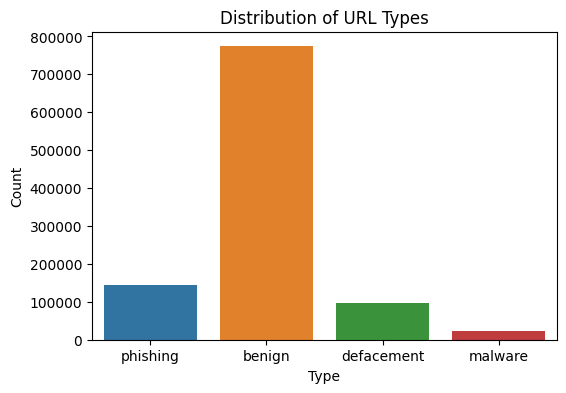

In [6]:
# ---  Distribution of URL Types ---
plt.figure(figsize=(6, 4))
sns.countplot(x='type', data=df)
plt.title('Distribution of URL Types')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

3. Generating WordClouds for Each URL Category

In [7]:
df_phish = df[df.type=='phishing']
df_malware = df[df.type=='malware']
df_deface = df[df.type=='defacement']
df_benign = df[df.type=='benign']

4. Checking Missing Data

In [8]:
#Check for missing values
print(df.isnull().sum())

url     0
type    0
dtype: int64


5. Encoding Target Labels

In [9]:
# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['type'])

In [10]:
df

,url,type,label_encoded
0,br-icloud.com.br,phishing,3
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1
...,...,...,...
1039399,https://news.gandaki-bazaar.training.np/contac...,defacement,1
1039400,https://www.sarkar-hospital.dev.np/about/PWNED...,defacement,1
1039401,https://news.yojana-bulletin.dev.np/about/H4ck...,defacement,1
1039402,https://info.bagmati-college.dev.np/contact/H4...,defacement,1


6. Features Extraction from URLs

In [11]:
# Suspicious keyword lists
suspicious_keywords = ['login', 'signin', 'verify', 'update', 'banking', 'account', 'secure', 'ebay', 'paypal']
brand_keywords = ['paypal','bank','amazon','google','facebook','apple','microsoft']

# Low-reputation TLDs
bad_tlds = ['xyz','top','gq','ml','cf','tk','club','click','zip','loan','work']

# Entropy function
def entropy(s):
    if len(s) == 0:
        return 0
    probs = [s.count(c)/len(s) for c in set(s)]
    return -sum(p * math.log2(p) for p in probs)


# ========================== FEATURE EXTRACTION ============================= #

def extract_features(url):
    features = {}

    parsed = urlparse(url)
    domain = parsed.netloc if parsed.netloc else url
    path = parsed.path
    query = parsed.query
    tld = domain.split('.')[-1]
    sld = domain.split('.')[0]

    # ------------------ A. URL STRUCTURE FEATURES (10) ------------------ #

    features['url_length'] = len(url)
    features['num_digits'] = sum(c.isdigit() for c in url)
    features['num_special_chars'] = sum(c in string.punctuation for c in url)
    features['num_subdomains'] = domain.count('.') - 1
    features['num_slashes'] = url.count('/')
    features['num_params'] = url.count('?')
    features['num_fragments'] = url.count('#')
    features['url_entropy'] = entropy(url)
    features['num_hyphens'] = domain.count('-')
    features['double_slash_in_path'] = int('//' in path[1:])

    # --------------------- B. DOMAIN FEATURES (7) ------------------------ #

    features['domain_length'] = len(domain)
    features['sld_length'] = len(sld)
    features['tld_length'] = len(tld)
    features['bad_tld_flag'] = int(tld in bad_tlds)
    features['has_ip'] = int(bool(re.search(r'\d+\.\d+\.\d+\.\d+', domain)))
    features['numeric_domain'] = int(domain.replace('.', '').isdigit())
    features['domain_tokens'] = len(sld.split('-'))

    # --------------------- C. PATH / QUERY FEATURES (5) ------------------ #

    features['path_length'] = len(path)
    features['num_directories'] = path.count('/')
    features['query_length'] = len(query)
    features['has_hex_encoding'] = int(bool(re.search(r'%[0-9a-fA-F]{2}', url)))
    features['repeated_chars'] = int(bool(re.search(r'(.)\1{3,}', url)))  # 4 or more repeated chars

    # ------------------ D. KEYWORD FEATURES (3) -------------------------- #

    features['has_suspicious_words'] = int(any(word in url.lower() for word in suspicious_keywords))
    features['brand_mimic'] = int(any(brand in url.lower() for brand in brand_keywords))
    features['has_unicode_or_punycode'] = int('xn--' in url.lower() or any(ord(c) > 127 for c in url))

    return pd.Series(features)


# ====================== APPLY FEATURES TO DATAFRAME ====================== #

features_df = df['url'].apply(extract_features)
df = pd.concat([df, features_df], axis=1)

df.head()

,url,type,label_encoded,url_length,num_digits,num_special_chars,num_subdomains,num_slashes,num_params,num_fragments,...,numeric_domain,domain_tokens,path_length,num_directories,query_length,has_hex_encoding,repeated_chars,has_suspicious_words,brand_mimic,has_unicode_or_punycode
0,br-icloud.com.br,phishing,3,16.0,0.0,3.0,1.0,0.0,0.0,0.0,...,0.0,2.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35.0,1.0,5.0,1.0,2.0,0.0,0.0,...,0.0,1.0,35.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31.0,1.0,5.0,1.0,3.0,0.0,0.0,...,0.0,1.0,31.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1,88.0,7.0,18.0,1.0,3.0,1.0,0.0,...,0.0,1.0,10.0,1.0,49.0,0.0,0.0,0.0,0.0,0.0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235.0,22.0,14.0,0.0,3.0,1.0,0.0,...,0.0,2.0,10.0,1.0,194.0,0.0,0.0,0.0,0.0,0.0


5. Plot of 5 Main Features

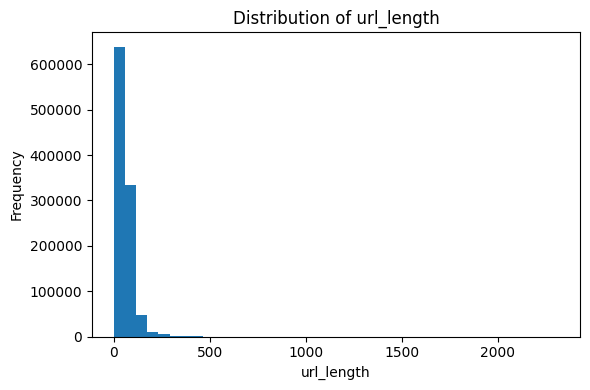

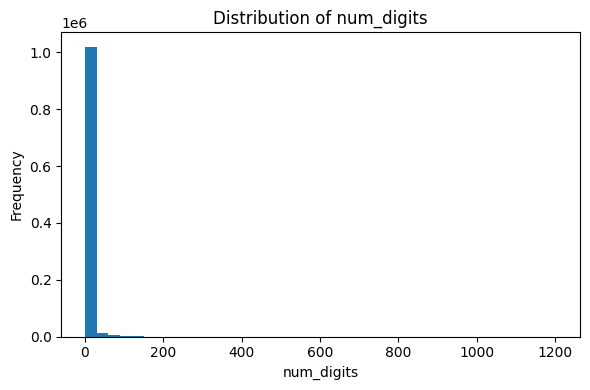

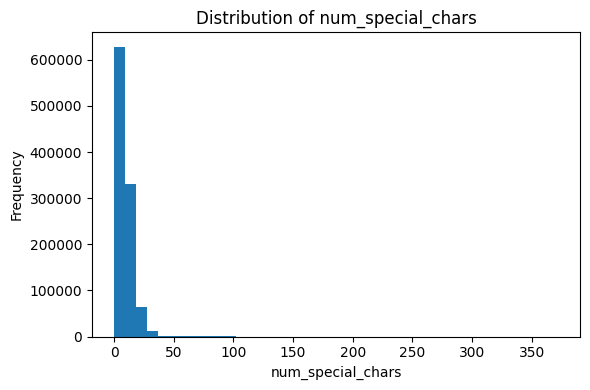

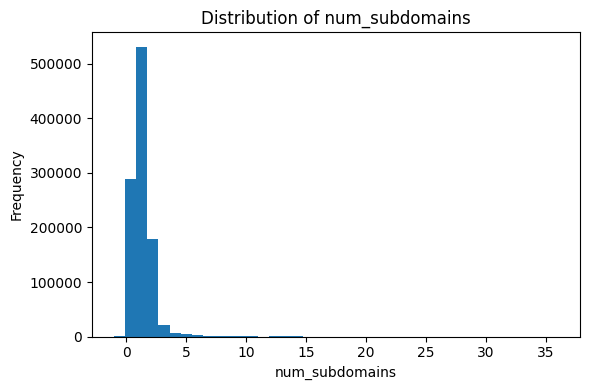

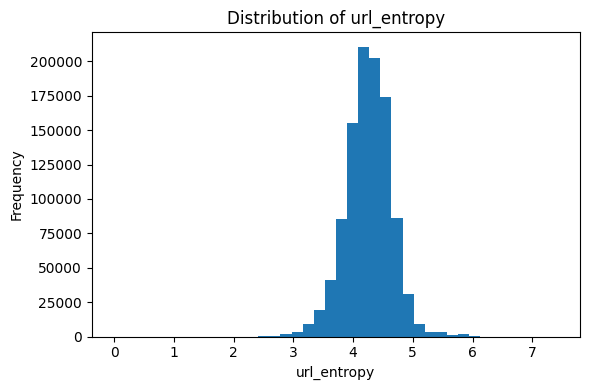

In [12]:
main_features = ['url_length', 'num_digits', 'num_special_chars', 'num_subdomains', 'url_entropy']

for feature in main_features:
    plt.figure(figsize=(6, 4))
    plt.hist(df[feature], bins=40)  # no colors specified
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

6. Feature Correlation Analysis

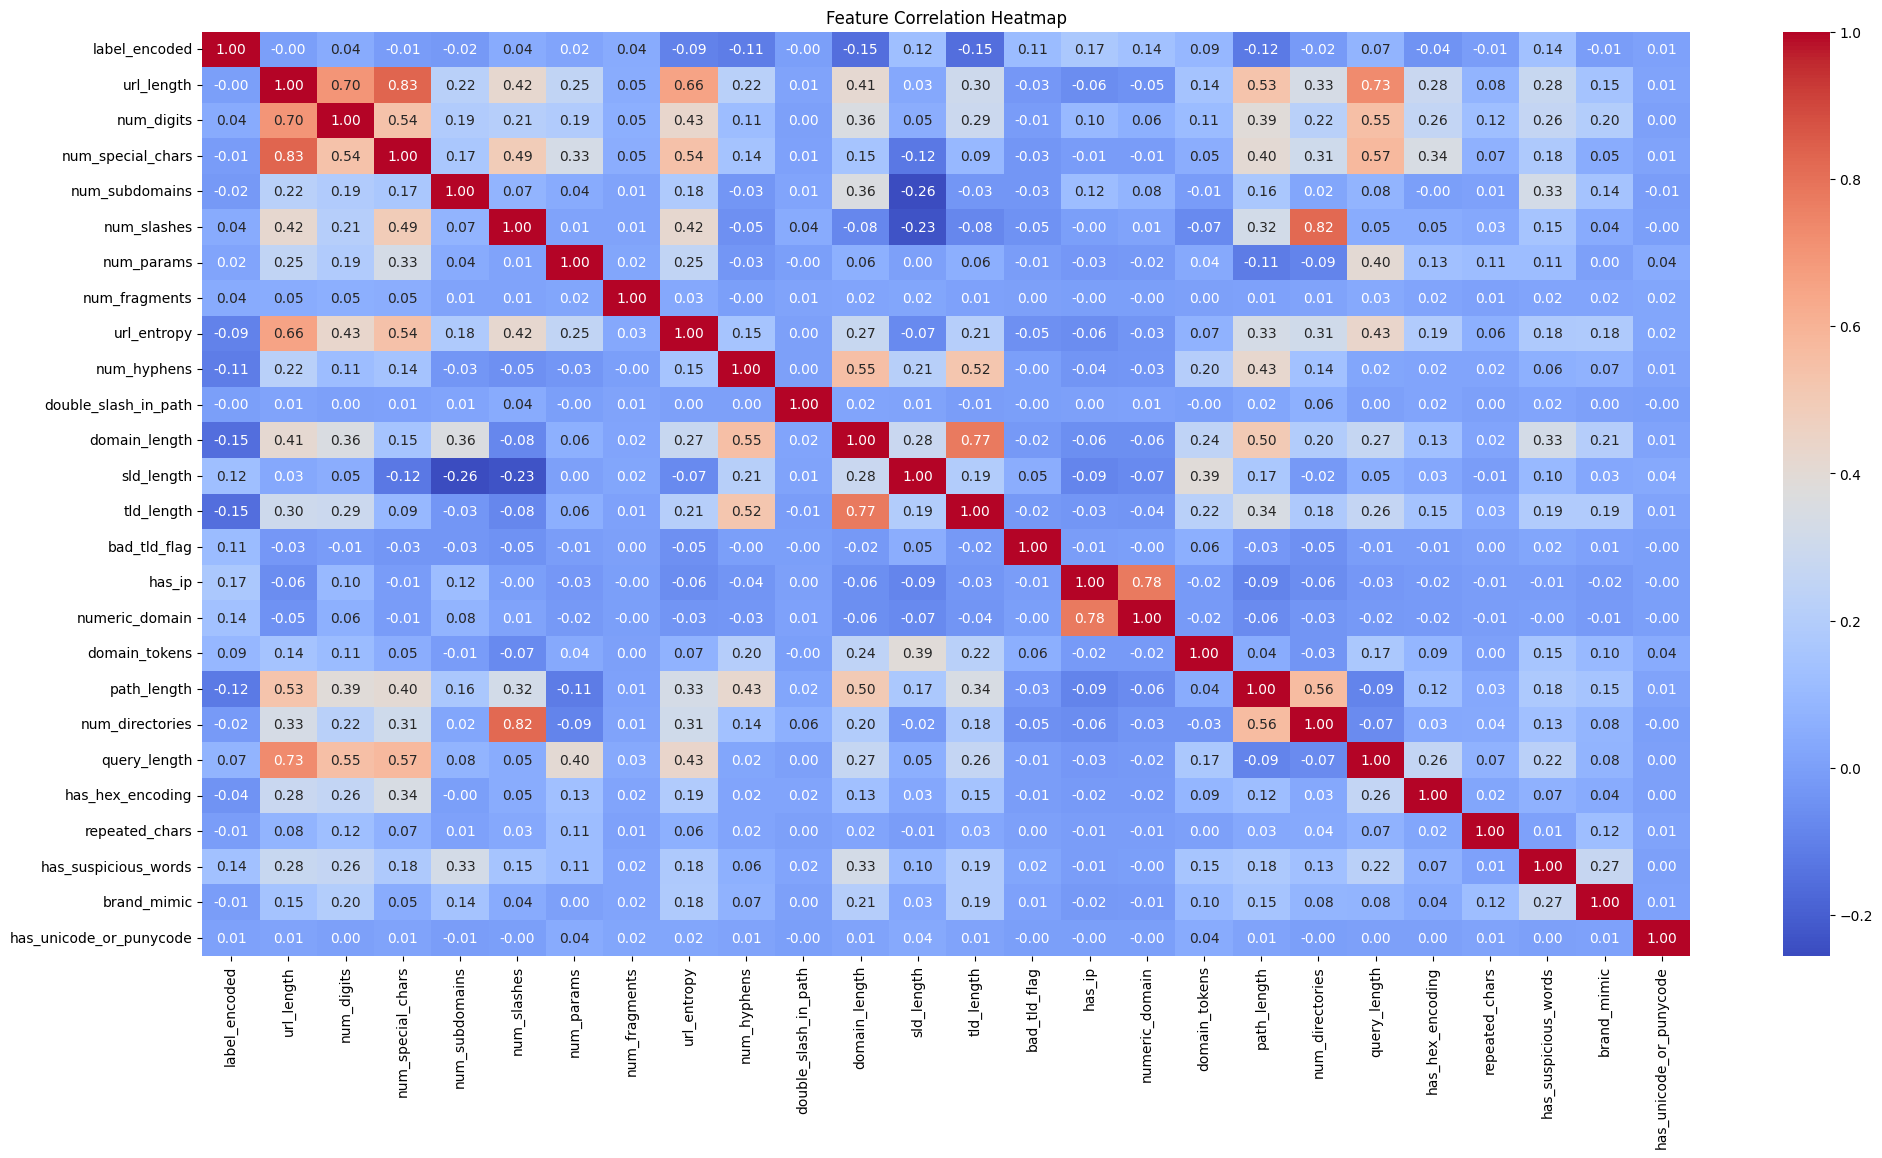

In [13]:
# --- 1 Correlation Heatmap ---
numeric_df = df.select_dtypes(include='number')
plt.figure(figsize=(24,12))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Feature Correlation Heatmap')
plt.show()

8. Model Training & Evaluation

In [14]:
# Define features and target
X = df.drop(columns=['url', 'type', 'label_encoded'])
y = df['label_encoded']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Dictionary to store model accuracies
accuracies = {}

# Train and evaluate models
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc
    print(f"Accuracy for {name}: {acc:.4f}")
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    print("\n")

Training Random Forest...
Accuracy for Random Forest: 0.9592
Classification Report for Random Forest:
              precision    recall  f1-score   support

      benign       0.97      0.98      0.98    154725
  defacement       0.93      0.91      0.92     19341
     malware       0.97      0.89      0.93      4742
    phishing       0.91      0.87      0.89     29070

    accuracy                           0.96    207878
   macro avg       0.95      0.91      0.93    207878
weighted avg       0.96      0.96      0.96    207878



Training K-Nearest Neighbors...
Accuracy for K-Nearest Neighbors: 0.9369
Classification Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

      benign       0.95      0.98      0.97    154725
  defacement       0.88      0.84      0.86     19341
     malware       0.93      0.87      0.90      4742
    phishing       0.88      0.80      0.84     29070

    accuracy                           0.94    207878
   macro avg   

9. Model Accuracy Comparison

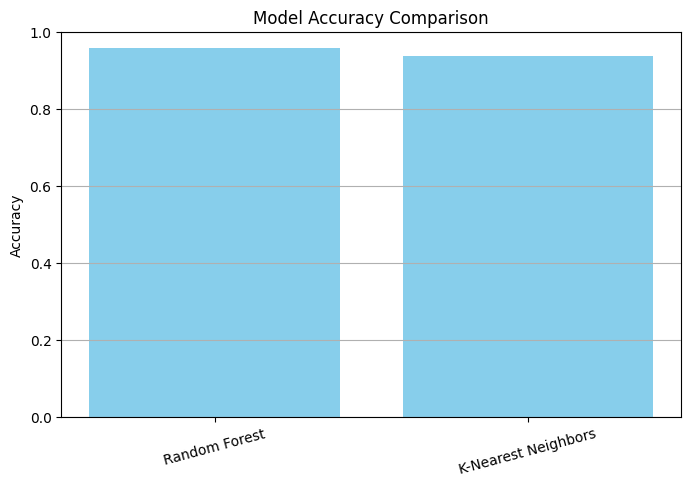

In [15]:
# Plot model accuracy comparison
plt.figure(figsize=(8, 5))
plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.show()

In [16]:
import joblib

# Save the trained Random Forest from the dictionary
joblib.dump(models['Random Forest'], '/kaggle/working/rf_url_model.pkl')

print("Random Forest model saved as '/kaggle/working/rf_url_model.pkl'")


Random Forest model saved as '/kaggle/working/rf_url_model.pkl'
